<a href="https://colab.research.google.com/github/th2l-aipn/IntroDL/blob/master/examples/2.%20CNN%20%2B%20MLP/2_Human_Gender_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
```
> Nguyen Hai Duong
> nhduong_3010@live.com
> Modified: Huynh Van Thong
> hvthong.298@gmail.com
> Chonnam National University
```
---

# Overview
- WIKI dataset (face images + gender + age + ...)
  + Goal: classifying human gender
  + Input: a 64x64 image
  + Output: gender (female or male)
- Defining an CNN+MLP for WIKI dataset
- Training and evaluating an CNN+MLP

# Import libraries

In [1]:
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import time
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
num_classes = 2   # male vs. female

## 1. Data

### Download data at https://drive.google.com/open?id=0BxINLo5jshCRYW8xODhNSlkyLTQ
This source code and npy files MUST be in the same location

In [3]:
# Download dataset
import requests
url1 = 'https://www.dropbox.com/s/t7lddenrmwv7u1o/64_64_5968_4098_val_x_onehot.npy?dl=1'
url2 = 'https://www.dropbox.com/s/qkqiuvbn8mwa4ej/64_64_5968_4098_val_y_onehot.npy?dl=1'
url3 = 'https://www.dropbox.com/s/4yijlzpdikwq9fy/64_64_11938_4098_train_x_onehot.npy?dl=1'
url4 = 'https://www.dropbox.com/s/cqwhr6nnzwsq31x/64_64_11938_4098_train_y_onehot.npy?dl=1'

r1 = requests.get(url1, allow_redirects=True)
open('64_64_5968_4098_val_x_onehot.npy', 'wb').write(r1.content)

r2 = requests.get(url2, allow_redirects=True)
open('64_64_5968_4098_val_y_onehot.npy', 'wb').write(r2.content)

r3 = requests.get(url3, allow_redirects=True)
open('64_64_11938_4098_train_x_onehot.npy', 'wb').write(r3.content)

r4 = requests.get(url4, allow_redirects=True)
open('64_64_11938_4098_train_y_onehot.npy', 'wb').write(r4.content)

!ls

64_64_11938_4098_train_x_onehot.npy  64_64_5968_4098_val_y_onehot.npy
64_64_11938_4098_train_y_onehot.npy  sample_data
64_64_5968_4098_val_x_onehot.npy


In [0]:
x_train = np.load('64_64_11938_4098_train_x_onehot.npy')
y_train = np.load('64_64_11938_4098_train_y_onehot.npy')
x_train = np.rot90(x_train, k=3, axes=(1, 2))

x_test = np.load('64_64_5968_4098_val_x_onehot.npy')
y_test = np.load('64_64_5968_4098_val_y_onehot.npy')
x_test = np.rot90(x_test, k=3, axes=(1, 2))

## 2. Declare model

In [5]:
# 64x64 portray image
input_image = Input(shape=(64, 64, 1), name='Input')

# conv, pooling layers + dropout
x = Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', name='conv1_1')(input_image)
x = Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', name='conv1_2')(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool1')(x)
x = Dropout(rate=0.2, name='conv_dropout1')(x)

x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', name='conv2_1')(x)
x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', name='conv2_2')(x)
x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', name='conv2_3')(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool2')(x)
x = Dropout(rate=0.2, name='conv_dropout2')(x)

x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='conv3_1')(x)
x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='conv3_2')(x)
x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='conv3_3')(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool3')(x)
x = Dropout(rate=0.2, name='conv_dropout3')(x)

x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', name='conv4_1')(x)
x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', name='conv4_2')(x)
x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', name='conv4_3')(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool4')(x)
x = Dropout(rate=0.2, name='conv_dropout4')(x)

x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', name='conv5_1')(x)
x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', name='conv5_2')(x)
x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', name='conv5_3')(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool5')(x)
x = Dropout(rate=0.2, name='conv_dropout5')(x)

# similar to the MLP example!
# matrix ---> vector
x = Flatten(name='flatten')(x)

# FC layers + dropout
x = Dense(units=1024, activation='relu', name='fc1')(x)
x = Dropout(rate=0.2, name='fc_dropout1')(x)

x = Dense(units=1024, activation='relu', name='fc2')(x)
x = Dropout(rate=0.2, name='fc_dropout2')(x)

output_label = Dense(units=num_classes, activation='softmax', name='fc3_10ways_softmax')(x)

# define model
model = Model(inputs=input_image, outputs=output_label, name='mnist_mlp')

# print model summary
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 64, 64, 1)         0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 64, 64, 16)        160       
_________________________________________________________________
conv1_2 (Conv2D)             (None, 64, 64, 16)        2320      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 32, 32, 16)        0         
_________________________________________________________________
conv_dropout1 (Dropout)      (None, 32, 32, 16)        0         
_________________________________________________________________
conv2_1 (Conv2D)     

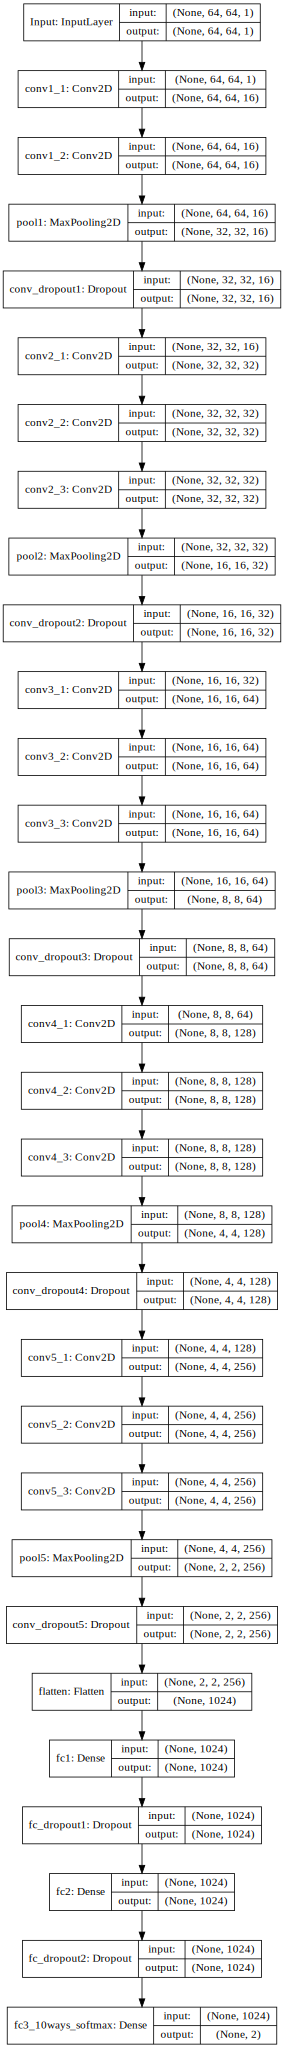

In [6]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## 3. Train defined model
- Note that the training history including loss and accuracy will be save in 'history' variable
- In case your system runs out of memory (OOM), try to decrease batch size

In [7]:
# declare learning rate, loss function, and model metric
loss = 'categorical_crossentropy'
lr = 0.0001
model.compile(loss=loss, optimizer=Adam(lr=lr), metrics=['accuracy'])

# train the model
batch_size = 128
epochs = 30

starting_time = time.time()
history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    batch_size=batch_size,
                    epochs=epochs)
print('> training time is %.4f minutes' % ((time.time() - starting_time)/60))

Instructions for updating:
Use tf.cast instead.
Train on 11938 samples, validate on 5968 samples
Epoch 1/30
11938/11938 [==============================] - 9s 731us/step - loss: 0.5446 - acc: 0.7867 - val_loss: 0.5285 - val_acc: 0.7885
Epoch 2/30
11938/11938 [==============================] - 4s 369us/step - loss: 0.5089 - acc: 0.7885 - val_loss: 0.4979 - val_acc: 0.7885
Epoch 3/30
11938/11938 [==============================] - 4s 368us/step - loss: 0.4928 - acc: 0.7885 - val_loss: 0.4756 - val_acc: 0.7885
Epoch 4/30
11938/11938 [==============================] - 4s 368us/step - loss: 0.4654 - acc: 0.8010 - val_loss: 0.4532 - val_acc: 0.8148
Epoch 5/30
11938/11938 [==============================] - 4s 368us/step - loss: 0.4505 - acc: 0.8136 - val_loss: 0.4486 - val_acc: 0.8103
Epoch 6/30
11938/11938 [==============================] - 4s 368us/step - loss: 0.4362 - acc: 0.8200 - val_loss: 0.4444 - val_acc: 0.8091
Epoch 7/30
11938/11938 [==============================] - 4s 370us/step - l

In [8]:
!nvidia-smi

Mon Jun  3 08:34:41 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    45W /  70W |   2339MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Training time
- Training time withTesla T4 is about 2.3240 minutes for 30 epochs
- Training time with Core i7 is around 109 minutes for 30 epochs

## 4. Evaluate trained model

In [9]:
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

5968/5968 [==============================] - 1s 178us/step
Test loss: 0.39986197820217934
Test accuracy: 0.8448391420911529


In [0]:
def int2gender(num):
    if num == 0:
        return 'female'
    else:
        return 'male'

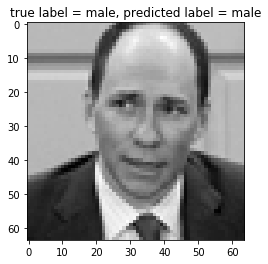

In [11]:
# select a test image randomly
random_test_index = np.random.choice(x_test.shape[0], size=1)[0]
test_img = x_test[random_test_index]
test_label = np.argmax(y_test[random_test_index])

# predict test image with trained model
pred_label = model.predict(np.expand_dims(test_img, axis=0))
pred_label = np.argmax(pred_label)

plt.imshow(test_img[:, :, 0], cmap='gray')
plt.title('true label = %s, predicted label = %s' % (int2gender(test_label), int2gender(pred_label)))
plt.show()